# ANN Optimized

In [4]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 124.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.8 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import gc
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, concatenate, GlobalAveragePooling1D

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

# Load pickled sentence embeddings
def load_embeddings(file_path):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return {k: np.array(v, dtype=np.float16) for k, v in data.items()}

# Define data generator
def data_generator(df, embedding_map):
    for _, row in df.iterrows():
        emb1 = embedding_map.get(row['sentence1_clean'])
        emb2 = embedding_map.get(row['sentence2_clean'])
        if emb1 is not None and emb2 is not None:
            yield (emb1.astype(np.float16), emb2.astype(np.float16)), np.float16(row['score'])

# Build ANN model
def build_ann_model(input_shape):
    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)

    pooled1 = GlobalAveragePooling1D()(input1)
    pooled2 = GlobalAveragePooling1D()(input2)

    abs_diff = Lambda(lambda x: tf.abs(x[0] - x[1]))([pooled1, pooled2])
    mult = Lambda(lambda x: x[0] * x[1])([pooled1, pooled2])

    merged = concatenate([pooled1, pooled2, abs_diff, mult])

    dense = Dense(128, activation='relu')(merged)
    drop = Dropout(0.3)(dense)
    output = Dense(1, activation='linear')(drop)

    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Load resources
embedding_path = "drive/MyDrive/sentence_to_embedding.pkl"
sentence_to_embedding = load_embeddings(embedding_path)

csv_path = "drive/MyDrive/rs2_augmented.csv"
df_full = pd.read_csv(csv_path)[['sentence1_clean', 'sentence2_clean', 'score']]

# Remove unknown embeddings
df_full = df_full[
    df_full['sentence1_clean'].isin(sentence_to_embedding) &
    df_full['sentence2_clean'].isin(sentence_to_embedding)
].reset_index(drop=True)

# Train-test split
df_train, df_val = train_test_split(df_full, test_size=0.2, random_state=42)

# Infer input shape
sample_embedding = next(iter(sentence_to_embedding.values()))
embedding_dim = sample_embedding.shape[1] if sample_embedding.ndim == 2 else sample_embedding.shape[0]
max_len = 30
input_shape = (max_len, embedding_dim)

# Create tf.data datasets
batch_size = 40

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(df_train, sentence_to_embedding),
    output_signature=(
        (tf.TensorSpec(shape=input_shape, dtype=tf.float16),
         tf.TensorSpec(shape=input_shape, dtype=tf.float16)),
        tf.TensorSpec(shape=(), dtype=tf.float16)
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(df_val, sentence_to_embedding),
    output_signature=(
        (tf.TensorSpec(shape=input_shape, dtype=tf.float16),
         tf.TensorSpec(shape=input_shape, dtype=tf.float16)),
        tf.TensorSpec(shape=(), dtype=tf.float16)
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Free memory
del df_full
gc.collect()

# Build and train model
model = build_ann_model(input_shape)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# Predictions (optional, be careful with RAM here)
#y_pred = model.predict(val_dataset).flatten()


Mounted at /content/drive/
Epoch 1/10
  26121/Unknown 638s 24ms/step - loss: 1.3898 - mae: 0.9573

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


26121/26121 ━━━━━━━━━━━━━━━━━━━━ 788s 30ms/step - loss: 1.3898 - mae: 0.9573 - val_loss: 0.7751 - val_mae: 0.7038
Epoch 2/10
26121/26121 ━━━━━━━━━━━━━━━━━━━━ 779s 30ms/step - loss: 0.8800 - mae: 0.7472 - val_loss: 0.5958 - val_mae: 0.6107
Epoch 3/10
26121/26121 ━━━━━━━━━━━━━━━━━━━━ 772s 30ms/step - loss: 0.7520 - mae: 0.6841 - val_loss: 0.5183 - val_mae: 0.5630
Epoch 4/10
26121/26121 ━━━━━━━━━━━━━━━━━━━━ 774s 30ms/step - loss: 0.6913 - mae: 0.6535 - val_loss: 0.4698 - val_mae: 0.5365
Epoch 5/10
26121/26121 ━━━━━━━━━━━━━━━━━━━━ 770s 29ms/step - loss: 0.6540 - mae: 0.6349 - val_loss: 0.4566 - val_mae: 0.5300
Epoch 6/10
26121/26121 ━━━━━━━━━━━━━━━━━━━━ 771s 30ms/step - loss: 0.6299 - mae: 0.6225 - val_loss: 0.4298 - val_mae: 0.5122
Epoch 7/10
26121/26121 ━━━━━━━━━━━━━━━━━━━━ 764s 29ms/step - loss: 0.6086 - mae: 0.6113 - val_loss: 0.4080 - val_mae: 0.4962
Epoch 8/10
26121/26121 ━━━━━━━━━━━━━━━━━━━━ 766s 29ms/step - loss: 0.5941 - mae: 0.6037 - val_loss: 0.4019 - val_mae: 0.4939
Epoch 9/10


In [8]:
BATCH_SIZE = 3000

# Recreate val_dataset without initial batching to avoid nested batches
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(df_val, sentence_to_embedding),
    output_signature=(
        (tf.TensorSpec(shape=input_shape, dtype=tf.float16),
         tf.TensorSpec(shape=input_shape, dtype=tf.float16)),
        tf.TensorSpec(shape=(), dtype=tf.float16)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # Apply desired batch size

y_pred = model.predict(val_dataset).flatten()



88/88 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [11]:
!pip install scipy

📈 Pearson Correlation:  0.9161
📊 Spearman Correlation: 0.9197


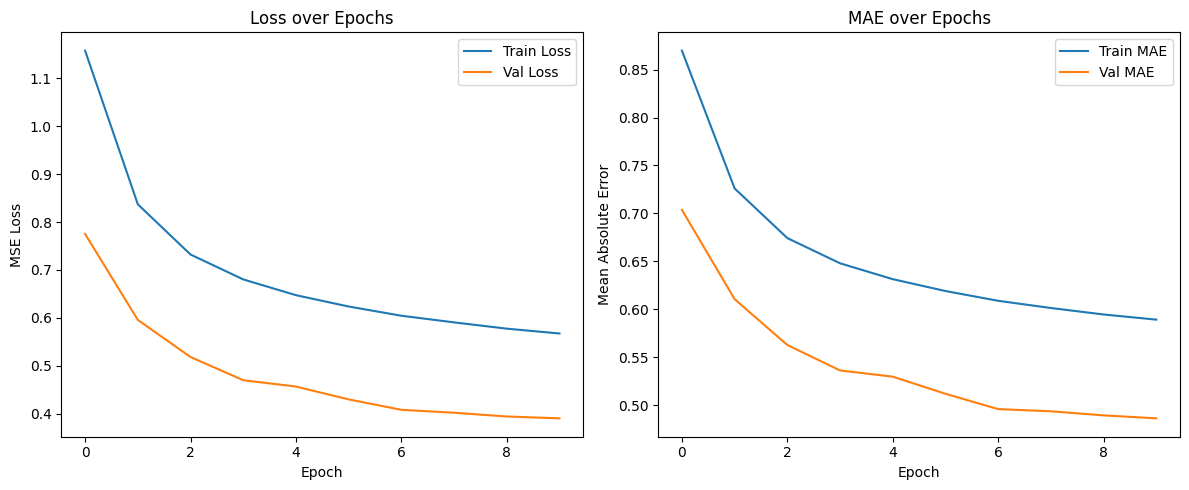

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

y_val = df_val['score'].values
pearson_corr, _ = pearsonr(y_val, y_pred)
spearman_corr, _ = spearmanr(y_val, y_pred)

print(f"📈 Pearson Correlation:  {pearson_corr:.4f}")
print(f"📊 Spearman Correlation: {spearman_corr:.4f}")

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Helper function
def evaluate(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred)
    }


print(evaluate(y_val, y_pred))

{'MSE': 0.3901545470506666, 'MAE': 0.48655805169397676, 'MAPE': 223370667555631.2, 'R²': 0.8264431119277557}
